## Transfer learning between data of T1D and T2PD with a 1DCNN model

In [1]:
# NECESSARY IMPORTS
import random 
import numpy as np 
import pandas as pd
from pprint import pprint
from pathlib import Path
import glob
import os

import tensorflow as tf 
from keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Flatten, Dense, Dropout, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import KFold


# Seed value for reproducability according to https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras
# seed values need to be defined in every cell to enable same results even if a different ordering is chosen

seed_value=3
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)



# FUNCTIONS 

# function which loads the data from a given folder and converts it to a numpy array
def load_data(path):
    # data of all subjects saved as csv files are loaded  
    csv_files = glob.glob(path + "/*.csv")

    # a list of the csv files from the folder in which each subject has its own file is created
    df_list = (pd.read_csv(file) for file in csv_files)

    # all DataFrames with corresponding glucose and heart-rate values in the right order are concatenated
    df  = pd.concat(df_list, ignore_index=True)
    df['HR'] = df['HR'].astype(float)
    df['Glucose'] = df['Glucose'].astype(float)
    df['HR2'] = df['HR2'].astype(float)
    df['Glucose2'] = df['Glucose2'].astype(float)
    df['HR3'] = df['HR3'].astype(float)
    df['Glucose3'] = df['Glucose3'].astype(float)
    df['HR4'] = df['HR4'].astype(float)
    df['Glucose4'] = df['Glucose4'].astype(float)
    df['HR5'] = df['HR5'].astype(float)
    df['Glucose5'] = df['Glucose5'].astype(float)
    df['HR6'] = df['HR6'].astype(float)
    df['Glucose6'] = df['Glucose6'].astype(float)
    df['Class'] = df['Class'].astype(int)
    df_y = df['Class']
    df = df[['Glucose','HR', 'Glucose2','HR2', 'Glucose3','HR3', 'Glucose4','HR4', 'Glucose5', 'HR5', 'Glucose6','HR6']]

    # the array is reshaped so that each time sequence consists of 6 rows of one glucose and one heartrate value
    X = df.to_numpy().reshape(-1,6,2)
    y = df_y.to_numpy().reshape(-1,1)

    # return the data and the corresponding labels
    return X, y


# function which undersamples the time series to have a balanced distribution of classes
# as input, a dictionary with wanted samples per class is given as well as the time series (X) with corresponding labels (y)
def undersampling(X,y, dict):
    
    # the X array needs to be resampled since the RandomUnderSampler only accepts 2D arrays
    # the needed shape is (-1, samples per time sequence for one parameter * parameters)
    new_X = X.reshape(-1,12)  
    undersample = RandomUnderSampler(sampling_strategy=dict, replacement=False)
    X_under, y_under = undersample.fit_resample(new_X, y)
    # reshape back to the original form
    X_under = X_under.reshape(-1,6,2)
    y_under = y_under.reshape(-1,1)

    return X_under, y_under


# function defining the 1DCNN model with one convolutional layer, which needs the undersampled time series (X_under) and the classes as input 
def Model_1DCNN(X_under, classes):

    model_1dCNN = Sequential()

    # Convolutional block
    model_1dCNN.add(Conv1D(filters=126, kernel_size=3,input_shape=[X_under.shape[1], X_under.shape[2]], activation='relu'))
    model_1dCNN.add(BatchNormalization())
    model_1dCNN.add(GlobalAveragePooling1D())

    model_1dCNN.add(Flatten())

    # Fully connected layers
    model_1dCNN.add(Dense(units=50, activation='relu'))
    model_1dCNN.add(Dropout(rate=0.3))
    model_1dCNN.add(Dense(units=25, activation='relu'))

    # Output layer with softmax activation function
    model_1dCNN.add(Dense(units=classes, activation='softmax'))

    # Model is compiled in every fold during 10 fold corss validation
    model_1dCNN.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])

    return model_1dCNN



# function calling the 1DCNN model with 10 fold cross validation, which takes the X_train, y_train, X_test, y_test data as input
# the train data consists of all time series of one diabetes group and the test data of the other diabetes group
# the number of classes is given to assign weights 
# the filename for the training and testing data is given to save the models and confusion matrices under the given name
# lastly a batchsize and epoch length is given

def start_model(X_train, y_train, X_test, y_test, classes, train_name, test_name, batchsize=16, epoch= 500):

    # early stopping callback is defined, which stops when the validation loss does not decrease 
    early_stopping = EarlyStopping(patience=10, monitor='val_loss', mode='min', verbose=0, restore_best_weights=True)
    # learning rate is decreased as well if the validation loss does not decrease 
    reduceLR =ReduceLROnPlateau(monitor='val_loss', patience= 3, verbose= 0, mode='min', factor=  0.2, min_lr = 1e-6) 
    checkpoint = ModelCheckpoint('CustomModel.weights.hdf5', monitor='val_loss', verbose=0,save_best_only=True, mode= 'min') 
    callbacks= [early_stopping, checkpoint, reduceLR]

    # it is checked if the model should be trained on 7 or 5 classes
    if (classes == 7):
        # the distribution of classes is estimated to calucate weights for each class
        labels_df = pd.DataFrame(y_train, columns = ['label'])
        class_occurences = np.bincount(labels_df['label'])
        total = class_occurences.sum()
        number_classes = len(class_occurences)

        # calculating weights for each class
        weight_for_0 = (1/class_occurences[0]) * (total/number_classes)
        weight_for_1 = (1/class_occurences[1]) * (total/number_classes)
        weight_for_2 = (1/class_occurences[2]) * (total/number_classes)
        weight_for_3 = (1/class_occurences[3]) * (total/number_classes)
        weight_for_4 = (1/class_occurences[4]) * (total/number_classes)
        weight_for_5= (1/class_occurences[5]) * (total/number_classes)
        weight_for_6 = (1/class_occurences[6]) * (total/number_classes)

        # assigning weights for classes
        class_weights = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3, 4: weight_for_4, 5: weight_for_5, 6: weight_for_6}

    elif (classes == 5):
        # estimating distribution of classes to calucate weights for each class
        labels_df = pd.DataFrame(y_train, columns = ['label'])
        class_occurences = np.bincount(labels_df['label'])
        total = class_occurences.sum()
        number_classes = len(class_occurences)

        # assigning weights for classes
        weight_for_0 = (1/class_occurences[0]) * (total/number_classes)
        weight_for_1 = (1/class_occurences[1]) * (total/number_classes)
        weight_for_2 = (1/class_occurences[2]) * (total/number_classes)
        weight_for_3 = (1/class_occurences[3]) * (total/number_classes)
        weight_for_6 = (1/class_occurences[6]) * (total/number_classes)

        class_weights = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3, 4: 0, 5: 0, 6: weight_for_6}

    # KFold is initialized with defined number of folds and shuffled since the dataset consists of multiple patients and is not 
    # dependend on the time as instances were removed during undersampling   
    num_folds = 10
    kfolds = KFold(n_splits=num_folds, shuffle=True)

    # empty lists in which the scores and variables for each fold will be stored are defined
    accuracies_CV = []
    actual_labels_CV = []
    predicted_labels_CV = []

    # It is iterated over each fold
    for train_idx, test_idx in kfolds.split(X_train):
        # the dataset if split into training and validation sets for the current fold
        X_train_fold, X_test_fold = X_train[train_idx,:], X_train[test_idx,:]
        y_train_fold, y_test_fold = y_train[train_idx], y_train[test_idx]

        # then, training data is split into training and validation to monitor the callback conditions
        X_train_fold, X_val_fold, y_train_fold, y_val_fold = train_test_split(
        X_train_fold, y_train_fold, test_size=0.20, shuffle = True)

        # the actual labels are stored to estimate the performance and the loss function
        actual_labels_CV = np.append(actual_labels_CV, y_test_fold)

        # each fold a new model is created and trained
        model_CV = Model_1DCNN(X_train, 7)

        model_CV.fit(X_train_fold, y_train_fold,
        validation_data=(X_val_fold, y_val_fold),
        epochs=epoch,
        batch_size=batchsize,
        callbacks=callbacks,
        class_weight = class_weights,
        verbose=0
        )
        # after training, the model is evaluated on the test set
        y_pred = model_CV.predict(X_test_fold)
        y_pred_CV = np.argmax(y_pred, axis=1)
        accuracy_CV = accuracy_score(y_test_fold, y_pred_CV)
        accuracies_CV.append(accuracy_CV)

        # the predicted labels for each fold are stored to calcualte the overall metrics and visualize the confusion matrix in the end
        predicted_labels_CV = np.append(predicted_labels_CV, y_pred_CV)

    # the mean and standard deviation of evaluation metrics are calculated and printed
    mean_accuracy_CV = np.mean(accuracies_CV)
    std_accuracy_CV = np.std(accuracies_CV)
    print(f"\nMean accuracy: {mean_accuracy_CV:.4f}, Standard deviation: {std_accuracy_CV:.4f} of trained model")

    # the confusion matrix is plotted and saved as well as the model
    ConfusionMatrixDisplay.from_predictions(actual_labels_CV, predicted_labels_CV, cmap=plt.cm.Blues)
    name_img_train = "Confusion_Matrices/%s.png" % (train_name)
    plt.savefig(name_img_train)
    plt.show()
    print('Report of Training:')
    print(classification_report(actual_labels_CV, predicted_labels_CV))
    name = "Models/%s.hdf5" % (train_name)
    model_CV.save(name)

    # finally, the model is evaluated on the test data, the confusion matrix is shown and saved
    model_CV.evaluate(X_test, y_test)
    predictions_1dCNN = model_CV.predict(X_test)
    y_pred_1dCNN = np.argmax(predictions_1dCNN, axis=1) 
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_1dCNN, cmap=plt.cm.Blues)
    name_img_test = "Confusion_Matrices/%s.png" % (test_name)
    plt.savefig(name_img_test)
    plt.show()
    print('Report of Testing:')
    print(classification_report(y_test, y_pred_1dCNN))


# function to test the trained D1NAMO model with the explored thresholds
# this function is only called for the threshold exploration and takes the name of the trained D1NAMO model,
# the time series (X_under_pre) and corresponding classes (y_under_pre) of the threshold and 
# the target name for the confusion matrix which is saved as input 
    
def Testing_from_D1NAMO(filename, X_under_pre, y_under_pre, target_name):
    # saved model is called 
    reconstructed_model = tf.keras.models.load_model(filename)
    # already trained model is evaluated on the given test data
    reconstructed_model.evaluate(X_under_pre, y_under_pre)
    predictions_1dCNN = reconstructed_model.predict(X_under_pre)
    # confusion matrix is plotted and saved
    y_pred_1dCNN = np.argmax(predictions_1dCNN, axis=1) 
    ConfusionMatrixDisplay.from_predictions(y_under_pre, y_pred_1dCNN, cmap=plt.cm.Blues)
    name_img_test = target_name 
    plt.savefig(name_img_test)
    plt.show()
    print('Report of Testing:')
    print(classification_report(y_under_pre, y_pred_1dCNN))

## Threshold 70

In [2]:
# paths are defined and the load data function is called to have a time series representation of the data

# path for the data of type 2 pre-diabetes patients with a hypoglycemia threshold of 70 mg/dL
path_pre = 'data/prediab/thresh70'
X_pre, y_pre = load_data(path_pre)

# path for the data of type 1 diabetes patients with a hypoglycemia threshold of 70 mg/dL
path_t1 = 'data/d1namo'
X_t1, y_t1 = load_data(path_t1)

Train data is BigLab and test data is D1NAMO with threshold 70


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 0s 775us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 955us/step

Mean accuracy: 0.4993, Standard deviation: 0.0745 of trained model


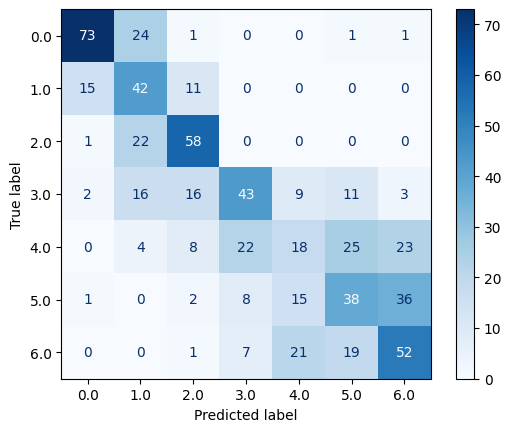

Report of Training:
              precision    recall  f1-score   support

         0.0       0.79      0.73      0.76       100
         1.0       0.39      0.62      0.48        68
         2.0       0.60      0.72      0.65        81
         3.0       0.54      0.43      0.48       100
         4.0       0.29      0.18      0.22       100
         5.0       0.40      0.38      0.39       100
         6.0       0.45      0.52      0.48       100

    accuracy                           0.50       649
   macro avg       0.49      0.51      0.49       649
weighted avg       0.50      0.50      0.49       649

20/20 [==============================] - 0s 372us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


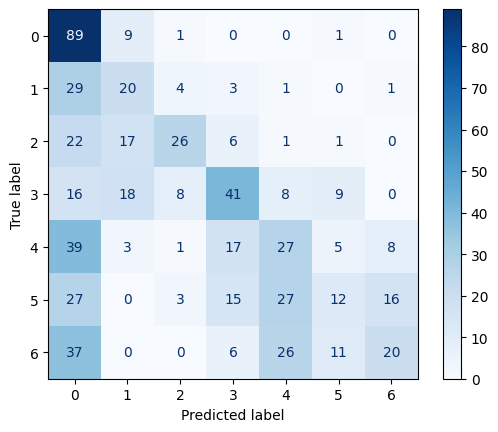

Report of Testing:
              precision    recall  f1-score   support

           0       0.34      0.89      0.50       100
           1       0.30      0.34      0.32        58
           2       0.60      0.36      0.45        73
           3       0.47      0.41      0.44       100
           4       0.30      0.27      0.28       100
           5       0.31      0.12      0.17       100
           6       0.44      0.20      0.28       100

    accuracy                           0.37       631
   macro avg       0.39      0.37      0.35       631
weighted avg       0.39      0.37      0.35       631

Train data is D1NAMO and test data is BigLab with threshold 70


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 934us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 1ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 984us/step

Mean accuracy: 0.5118, Standard deviation: 0.0444 of trained model


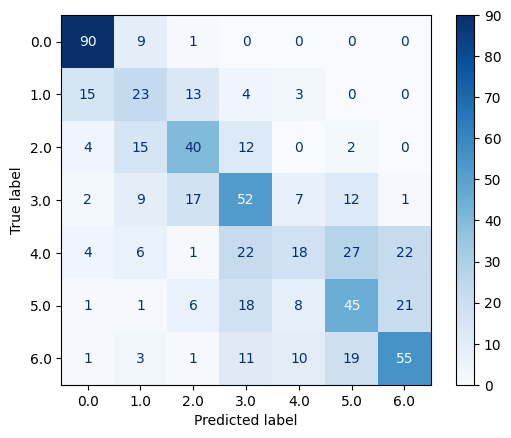

Report of Training:
              precision    recall  f1-score   support

         0.0       0.77      0.90      0.83       100
         1.0       0.35      0.40      0.37        58
         2.0       0.51      0.55      0.53        73
         3.0       0.44      0.52      0.47       100
         4.0       0.39      0.18      0.25       100
         5.0       0.43      0.45      0.44       100
         6.0       0.56      0.55      0.55       100

    accuracy                           0.51       631
   macro avg       0.49      0.51      0.49       631
weighted avg       0.50      0.51      0.50       631

21/21 [==============================] - 0s 396us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


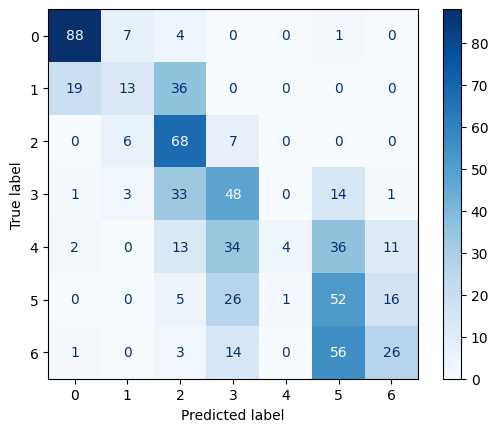

Report of Testing:
              precision    recall  f1-score   support

           0       0.79      0.88      0.83       100
           1       0.45      0.19      0.27        68
           2       0.42      0.84      0.56        81
           3       0.37      0.48      0.42       100
           4       0.80      0.04      0.08       100
           5       0.33      0.52      0.40       100
           6       0.48      0.26      0.34       100

    accuracy                           0.46       649
   macro avg       0.52      0.46      0.41       649
weighted avg       0.53      0.46      0.42       649



In [5]:
# threshold 70 with max. 100 samples and 7 classes 

# The seed value needs to be called every time so that in every cell and order the model is reproduceable
# Seed value for reproducability according to https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras
seed_value=3
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# dictionaries are defined to undersample the data for each class, then the undersampling function is called
dict_under = {0: 100, 1: 68 , 2: 81, 3: 100, 4: 100, 5: 100, 6: 100}
X_under_pre, y_under_pre = undersampling(X_pre, y_pre, dict_under)
dict_under_t1 = {0: 100, 1: 58, 2: 73, 3: 100, 4: 100, 5: 100, 6: 100}
X_under_t1, y_under_t1 = undersampling(X_t1, y_t1, dict_under_t1)

# the function start_model is called to initialize the model and visualize the confusion matrices
print("Train data is BigLab and test data is D1NAMO with threshold 70")
start_model(X_under_pre, y_under_pre, X_under_t1, y_under_t1, 7,"1DCNN_Trained_BigLab_70_7", "1DCNN_Tested_D1NAMO_70_7", batchsize=16, epoch= 500)
print("Train data is D1NAMO and test data is BigLab with threshold 70")
start_model(X_under_t1, y_under_t1, X_under_pre, y_under_pre, 7, "1DCNN_Trained_D1NAMO_70_7", "1DCNN_Tested_BigLab_70_7", batchsize=16, epoch= 500)

Train data is BigLab and test data is D1NAMO with threshold 70


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 1ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 926us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 1ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 997us/step

Mean accuracy: 0.7016, Standard deviation: 0.0597 of trained model


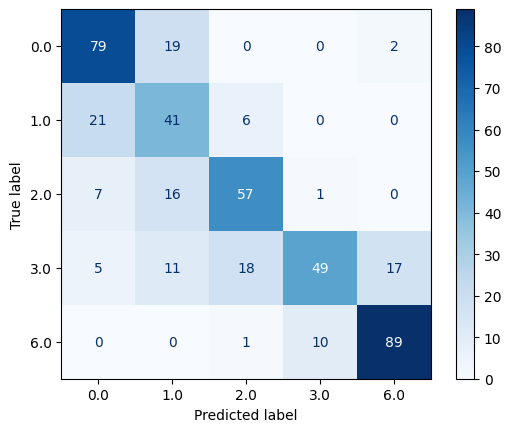

Report of Training:
              precision    recall  f1-score   support

         0.0       0.71      0.79      0.75       100
         1.0       0.47      0.60      0.53        68
         2.0       0.70      0.70      0.70        81
         3.0       0.82      0.49      0.61       100
         6.0       0.82      0.89      0.86       100

    accuracy                           0.70       449
   macro avg       0.70      0.70      0.69       449
weighted avg       0.72      0.70      0.70       449

14/14 [==============================] - 0s 398us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


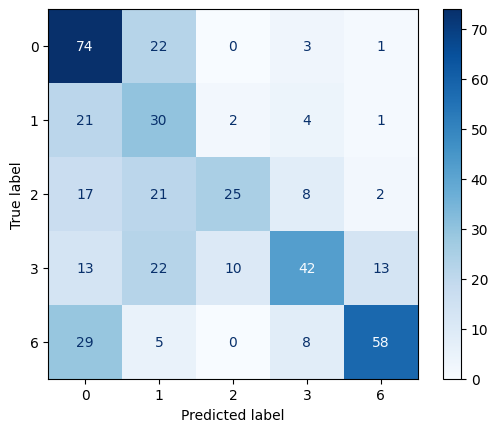

Report of Testing:
              precision    recall  f1-score   support

           0       0.48      0.74      0.58       100
           1       0.30      0.52      0.38        58
           2       0.68      0.34      0.45        73
           3       0.65      0.42      0.51       100
           6       0.77      0.58      0.66       100

    accuracy                           0.53       431
   macro avg       0.58      0.52      0.52       431
weighted avg       0.60      0.53      0.54       431

Train data is D1NAMO and test data is BigLab with threshold 70


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 1ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 844us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 1ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 895us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 998us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 965us/step

Mean accuracy: 0.6729, Standard deviation: 0.0486 of trained model


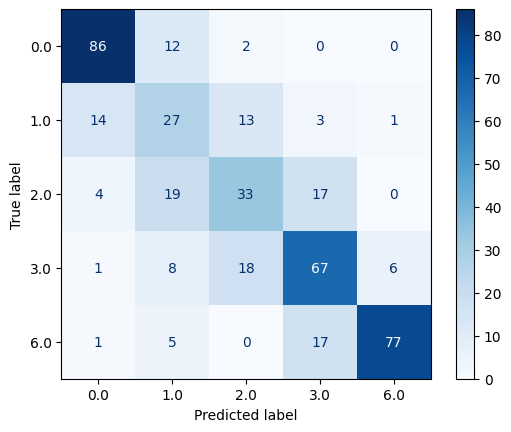

Report of Training:
              precision    recall  f1-score   support

         0.0       0.81      0.86      0.83       100
         1.0       0.38      0.47      0.42        58
         2.0       0.50      0.45      0.47        73
         3.0       0.64      0.67      0.66       100
         6.0       0.92      0.77      0.84       100

    accuracy                           0.67       431
   macro avg       0.65      0.64      0.64       431
weighted avg       0.69      0.67      0.68       431

15/15 [==============================] - 0s 374us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


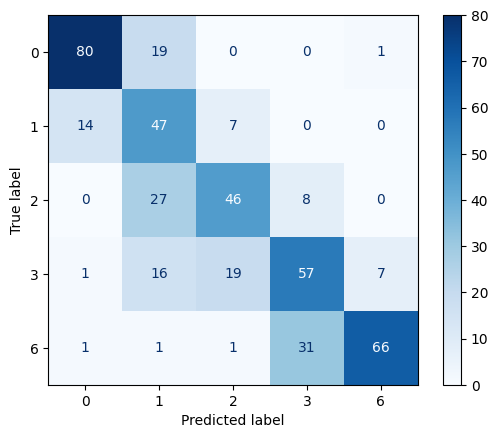

Report of Testing:
              precision    recall  f1-score   support

           0       0.83      0.80      0.82       100
           1       0.43      0.69      0.53        68
           2       0.63      0.57      0.60        81
           3       0.59      0.57      0.58       100
           6       0.89      0.66      0.76       100

    accuracy                           0.66       449
   macro avg       0.68      0.66      0.66       449
weighted avg       0.69      0.66      0.67       449



In [6]:
# threshold 70 with 100 samples and 5 classes

# The seed value needs to be called every time so that in every cell and order the model is reproduceable
# Seed value for reproducability according to https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras
seed_value=3
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# dictionaries are defined to undersample the data for each class, then the undersampling function is called
dict_under = {0: 100, 1: 68 , 2: 81, 3: 100, 4: 0, 5: 0, 6: 100}
X_under_pre, y_under_pre = undersampling(X_pre, y_pre, dict_under)
dict_under_t1 = {0: 100, 1: 58, 2: 73, 3: 100, 4: 0, 5: 0, 6: 100}
X_under_t1, y_under_t1 = undersampling(X_t1, y_t1, dict_under_t1)

# the function start_model is called to initialize the model and visualize the confusion matrices
print("Train data is BigLab and test data is D1NAMO with threshold 70")
start_model(X_under_pre, y_under_pre, X_under_t1, y_under_t1, 5,"1DCNN_Trained_BigLab_70", "1DCNN_Tested_D1NAMO_70", batchsize=16, epoch= 500)
print("Train data is D1NAMO and test data is BigLab with threshold 70")
start_model(X_under_t1, y_under_t1, X_under_pre, y_under_pre, 5,"1DCNN_Trained_D1NAMO_70", "1DCNN_Tested_BigLab_70", batchsize=16, epoch= 500)

Train data is BigLab and test data is D1NAMO with threshold 70


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 0s 780us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 0s 783us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 0s 641us/step

Mean accuracy: 0.7312, Standard deviation: 0.0504 of trained model


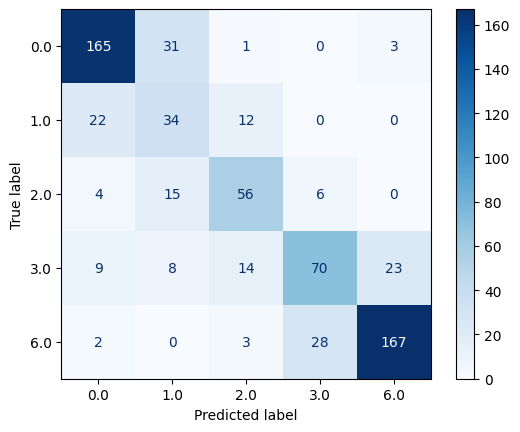

Report of Training:
              precision    recall  f1-score   support

         0.0       0.82      0.82      0.82       200
         1.0       0.39      0.50      0.44        68
         2.0       0.65      0.69      0.67        81
         3.0       0.67      0.56      0.61       124
         6.0       0.87      0.83      0.85       200

    accuracy                           0.73       673
   macro avg       0.68      0.68      0.68       673
weighted avg       0.74      0.73      0.73       673

21/21 [==============================] - 0s 359us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


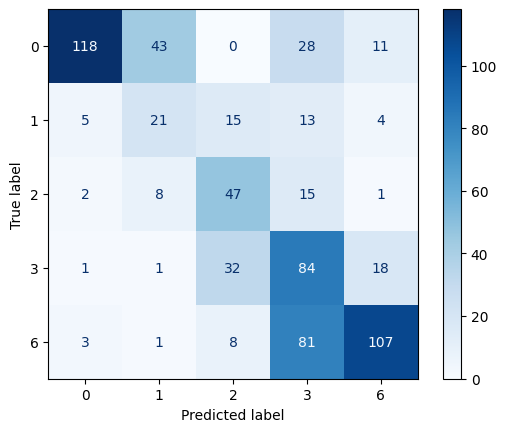

Report of Testing:
              precision    recall  f1-score   support

           0       0.91      0.59      0.72       200
           1       0.28      0.36      0.32        58
           2       0.46      0.64      0.54        73
           3       0.38      0.62      0.47       136
           6       0.76      0.54      0.63       200

    accuracy                           0.57       667
   macro avg       0.56      0.55      0.53       667
weighted avg       0.65      0.57      0.59       667

Train data is D1NAMO and test data is BigLab with threshold 70


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 0s 623us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 0s 780us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 0s 692us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 0s 691us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 0s 745us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 0s 646us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 0s 597us/step

Mean accuracy: 0.7660, Standard deviation: 0.0403 of trained model


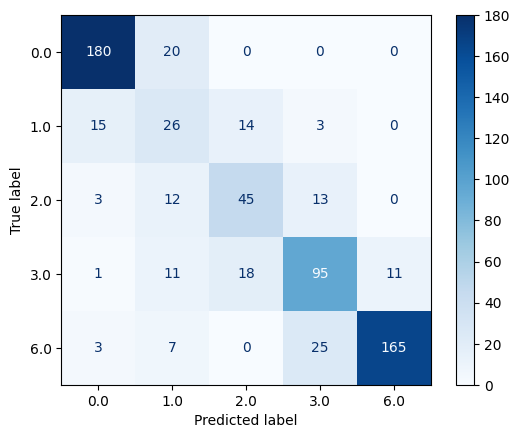

Report of Training:
              precision    recall  f1-score   support

         0.0       0.89      0.90      0.90       200
         1.0       0.34      0.45      0.39        58
         2.0       0.58      0.62      0.60        73
         3.0       0.70      0.70      0.70       136
         6.0       0.94      0.82      0.88       200

    accuracy                           0.77       667
   macro avg       0.69      0.70      0.69       667
weighted avg       0.78      0.77      0.77       667

22/22 [==============================] - 0s 340us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


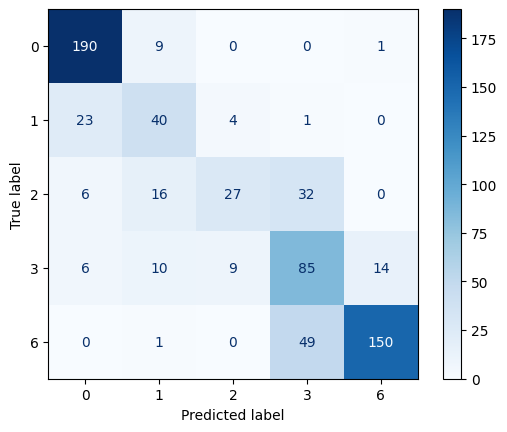

Report of Testing:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89       200
           1       0.53      0.59      0.56        68
           2       0.68      0.33      0.45        81
           3       0.51      0.69      0.58       124
           6       0.91      0.75      0.82       200

    accuracy                           0.73       673
   macro avg       0.69      0.66      0.66       673
weighted avg       0.75      0.73      0.73       673



In [7]:
# Threshold 70 with sampling 200 and 5 classes

# The seed value needs to be called every time so that in every cell and order the model is reproduceable
# Seed value for reproducability according to https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras
seed_value=3
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# dictionaries are defined to undersample the data for each class, then the undersampling function is called
dict_under ={0: 200, 1: 68 , 2: 81, 3: 124, 4: 0, 5: 0, 6: 200}
X_under_pre, y_under_pre = undersampling(X_pre, y_pre, dict_under)
dict_under_t1 ={0: 200, 1: 58, 2: 73, 3: 136, 4: 0, 5: 0, 6: 200}
X_under_t1, y_under_t1 = undersampling(X_t1, y_t1, dict_under_t1)

# the function start_model is called to initialize the model and visualize the confusion matrices
print("Train data is BigLab and test data is D1NAMO with threshold 70")
start_model(X_under_pre, y_under_pre, X_under_t1, y_under_t1, 5, "1DCNN_Trained_BigLab_70_200", "1DCNN_Tested_D1NAMO_70_200", batchsize=32, epoch= 500)
print("Train data is D1NAMO and test data is BigLab with threshold 70")
start_model(X_under_t1, y_under_t1, X_under_pre, y_under_pre, 5, "1DCNN_Trained_D1NAMO_70_200", "1DCNN_Tested_BigLab_70_200", batchsize=32, epoch= 500)


Train data is BigLab and test data is D1NAMO with threshold 70


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 0s 659us/step

Mean accuracy: 0.7475, Standard deviation: 0.0354 of trained model


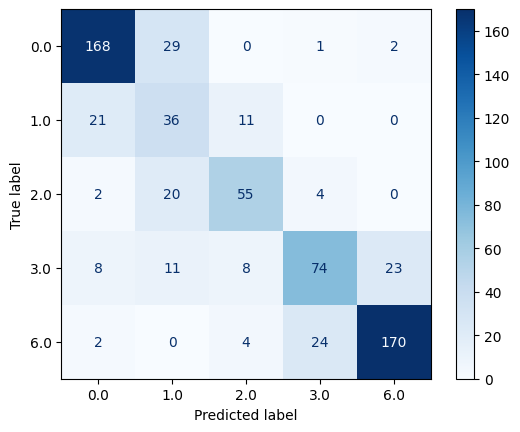

Report of Training:
              precision    recall  f1-score   support

         0.0       0.84      0.84      0.84       200
         1.0       0.38      0.53      0.44        68
         2.0       0.71      0.68      0.69        81
         3.0       0.72      0.60      0.65       124
         6.0       0.87      0.85      0.86       200

    accuracy                           0.75       673
   macro avg       0.70      0.70      0.70       673
weighted avg       0.76      0.75      0.75       673

28/28 [==============================] - 0s 349us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


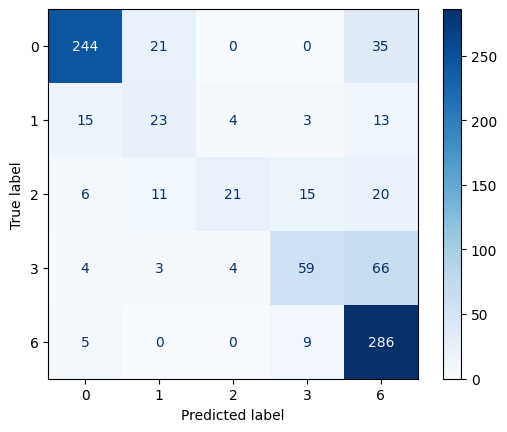

Report of Testing:
              precision    recall  f1-score   support

           0       0.89      0.81      0.85       300
           1       0.40      0.40      0.40        58
           2       0.72      0.29      0.41        73
           3       0.69      0.43      0.53       136
           6       0.68      0.95      0.79       300

    accuracy                           0.73       867
   macro avg       0.68      0.58      0.60       867
weighted avg       0.74      0.73      0.71       867

Train data is D1NAMO and test data is BigLab with threshold 70


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 0s 727us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 0s 655us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 0s 672us/step

Mean accuracy: 0.7891, Standard deviation: 0.0717 of trained model


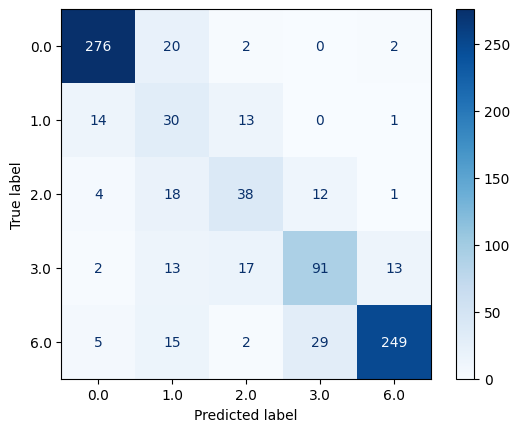

Report of Training:
              precision    recall  f1-score   support

         0.0       0.92      0.92      0.92       300
         1.0       0.31      0.52      0.39        58
         2.0       0.53      0.52      0.52        73
         3.0       0.69      0.67      0.68       136
         6.0       0.94      0.83      0.88       300

    accuracy                           0.79       867
   macro avg       0.68      0.69      0.68       867
weighted avg       0.81      0.79      0.80       867

22/22 [==============================] - 0s 370us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


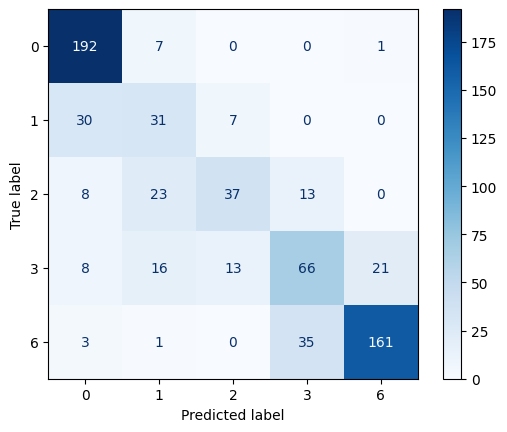

Report of Testing:
              precision    recall  f1-score   support

           0       0.80      0.96      0.87       200
           1       0.40      0.46      0.42        68
           2       0.65      0.46      0.54        81
           3       0.58      0.53      0.55       124
           6       0.88      0.81      0.84       200

    accuracy                           0.72       673
   macro avg       0.66      0.64      0.65       673
weighted avg       0.72      0.72      0.72       673



In [8]:
# Threshold 70 with sampling 300 for D1NAMO and 200 for BigLab and 5 classes

# The seed value needs to be called every time so that in every cell and order the model is reproduceable
# Seed value for reproducability according to https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras
seed_value=3
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# dictionaries are defined to undersample the data for each class, then the undersampling function is called
dict_under = {0: 200, 1: 68 , 2: 81, 3: 124, 4: 0, 5: 0, 6: 200}
X_under_pre, y_under_pre = undersampling(X_pre, y_pre, dict_under)
dict_under_t1 = {0: 300, 1: 58, 2: 73, 3: 136, 4: 0, 5: 0, 6: 300}
X_under_t1, y_under_t1 = undersampling(X_t1, y_t1, dict_under_t1)

# the function start_model is called to initialize the model and visualize the confusion matrices
print("Train data is BigLab and test data is D1NAMO with threshold 70")
start_model(X_under_pre, y_under_pre, X_under_t1, y_under_t1, 5,"1DCNN_Trained_BigLab_70_300", "1DCNN_Tested_D1NAMO_70_300", batchsize=25, epoch= 500)
print("Train data is D1NAMO and test data is BigLab with threshold 70")
start_model(X_under_t1, y_under_t1, X_under_pre, y_under_pre, 5,"1DCNN_Trained_D1NAMO_70_300", "1DCNN_Tested_BigLab_70_300", batchsize=25, epoch= 500)

Train data is BigLab and test data is D1NAMO with threshold 70


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 1ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 1ms/step

Mean accuracy: 0.6750, Standard deviation: 0.0591 of trained model


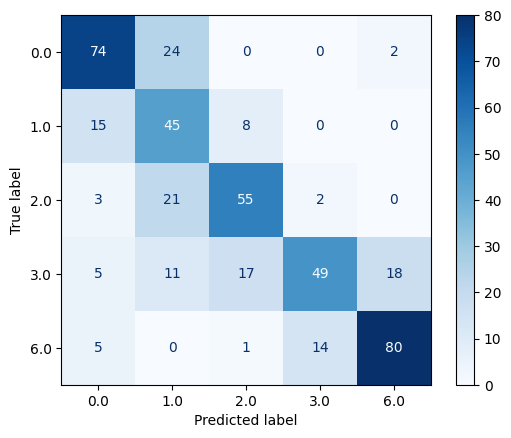

Report of Training:
              precision    recall  f1-score   support

         0.0       0.73      0.74      0.73       100
         1.0       0.45      0.66      0.53        68
         2.0       0.68      0.68      0.68        81
         3.0       0.75      0.49      0.59       100
         6.0       0.80      0.80      0.80       100

    accuracy                           0.67       449
   macro avg       0.68      0.67      0.67       449
weighted avg       0.70      0.67      0.68       449

14/14 [==============================] - 0s 405us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


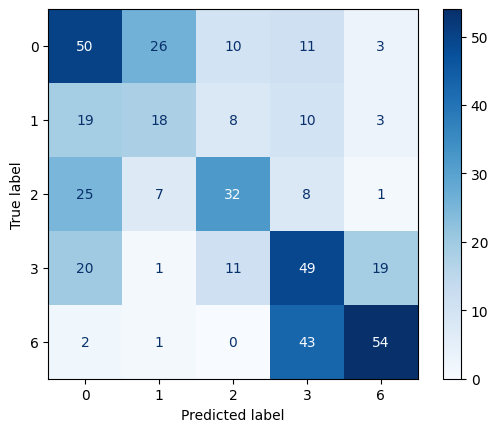

Report of Testing:
              precision    recall  f1-score   support

           0       0.43      0.50      0.46       100
           1       0.34      0.31      0.32        58
           2       0.52      0.44      0.48        73
           3       0.40      0.49      0.44       100
           6       0.68      0.54      0.60       100

    accuracy                           0.47       431
   macro avg       0.48      0.46      0.46       431
weighted avg       0.49      0.47      0.47       431

Train data is D1NAMO and test data is BigLab with threshold 70


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 1ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 918us/step

Mean accuracy: 0.6634, Standard deviation: 0.0674 of trained model


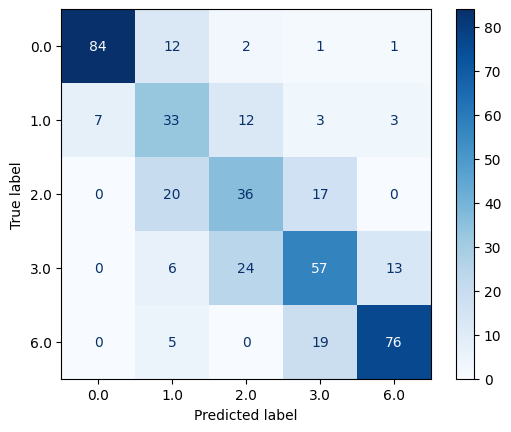

Report of Training:
              precision    recall  f1-score   support

         0.0       0.92      0.84      0.88       100
         1.0       0.43      0.57      0.49        58
         2.0       0.49      0.49      0.49        73
         3.0       0.59      0.57      0.58       100
         6.0       0.82      0.76      0.79       100

    accuracy                           0.66       431
   macro avg       0.65      0.65      0.65       431
weighted avg       0.68      0.66      0.67       431

15/15 [==============================] - 0s 403us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


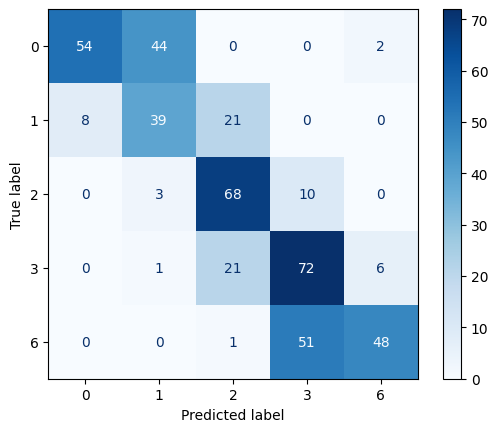

Report of Testing:
              precision    recall  f1-score   support

           0       0.87      0.54      0.67       100
           1       0.45      0.57      0.50        68
           2       0.61      0.84      0.71        81
           3       0.54      0.72      0.62       100
           6       0.86      0.48      0.62       100

    accuracy                           0.63       449
   macro avg       0.67      0.63      0.62       449
weighted avg       0.68      0.63      0.63       449



In [9]:
# Threshold 70 with sampling 100 and 5 classes and seed number 44

# The seed value needs to be called every time so that in every cell and order the model is reproduceable
# Seed value for reproducability according to https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras
seed_value=44
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# dictionaries are defined to undersample the data for each class, then the undersampling function is called
dict_under = {0: 100, 1: 68 , 2: 81, 3: 100, 4: 0, 5: 0, 6: 100}
X_under_pre, y_under_pre = undersampling(X_pre, y_pre, dict_under)
dict_under_t1 = {0: 100, 1: 58, 2: 73, 3: 100, 4: 0, 5: 0, 6: 100}
X_under_t1, y_under_t1 = undersampling(X_t1, y_t1, dict_under_t1)

# the function start_model is called to initialize the model and visualize the confusion matrices
print("Train data is BigLab and test data is D1NAMO with threshold 70")
start_model(X_under_pre, y_under_pre, X_under_t1, y_under_t1, 5,"1DCNN_Trained_BigLab_70_seed44", "1DCNN_Tested_D1NAMO_70_seed44", batchsize=16, epoch= 500)
print("Train data is D1NAMO and test data is BigLab with threshold 70")
start_model(X_under_t1, y_under_t1, X_under_pre, y_under_pre,5, "1DCNN_Trained_D1NAMO_70_seed44", "1DCNN_Tested_BigLab_70_seed44", batchsize=16, epoch= 500)


## Threshold 75

In [10]:
# paths are defined and the load data function is called to have a time series representation of the data

# path for the data of type 2 pre-diabetes patients with a hypoglycemia threshold of 75 mg/dL
path_pre = 'data/prediab/thresh75'
X_pre, y_pre = load_data(path_pre)

# path for the data of type 1 diabetes patients with a hypoglycemia threshold of 70 mg/dL
path_t1 = 'data/d1namo'
X_t1, y_t1 = load_data(path_t1)

Train data is BigLab and test data is D1NAMO with threshold 75


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 0s 723us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 0s 674us/step

Mean accuracy: 0.7134, Standard deviation: 0.0820 of trained model


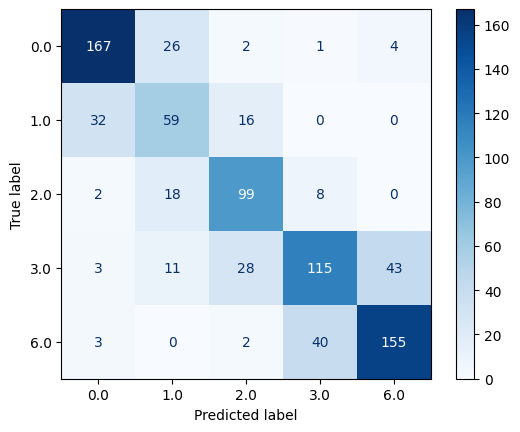

Report of Training:
              precision    recall  f1-score   support

         0.0       0.81      0.83      0.82       200
         1.0       0.52      0.55      0.53       107
         2.0       0.67      0.78      0.72       127
         3.0       0.70      0.57      0.63       200
         6.0       0.77      0.78      0.77       200

    accuracy                           0.71       834
   macro avg       0.69      0.70      0.70       834
weighted avg       0.71      0.71      0.71       834

14/14 [==============================] - 0s 368us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


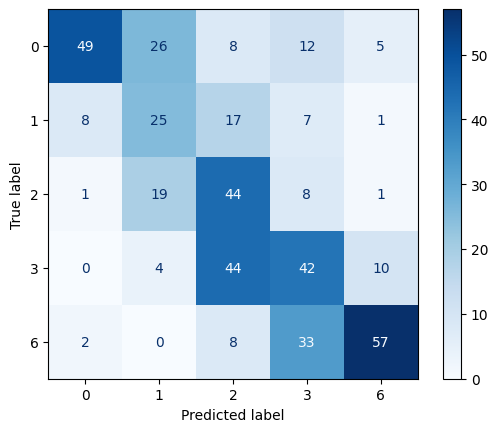

Report of Testing:
              precision    recall  f1-score   support

           0       0.82      0.49      0.61       100
           1       0.34      0.43      0.38        58
           2       0.36      0.60      0.45        73
           3       0.41      0.42      0.42       100
           6       0.77      0.57      0.66       100

    accuracy                           0.50       431
   macro avg       0.54      0.50      0.50       431
weighted avg       0.57      0.50      0.52       431

Train data is D1NAMO and test data is BigLab with threshold 75
27/27 [==============================] - 0s 342us/step


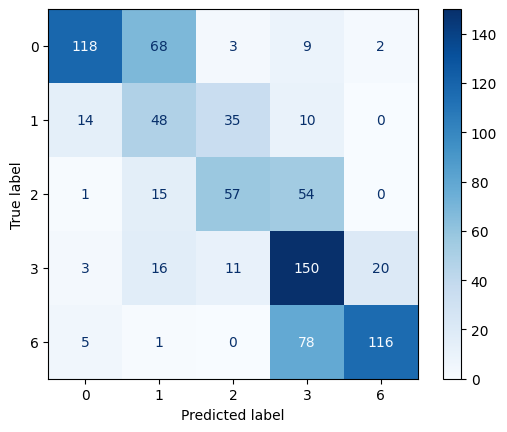

Report of Testing:
              precision    recall  f1-score   support

           0       0.84      0.59      0.69       200
           1       0.32      0.45      0.38       107
           2       0.54      0.45      0.49       127
           3       0.50      0.75      0.60       200
           6       0.84      0.58      0.69       200

    accuracy                           0.59       834
   macro avg       0.61      0.56      0.57       834
weighted avg       0.65      0.59      0.60       834



In [11]:
# Threshold 75 with sampling 200 and 5 classes

# The seed value needs to be called every time so that in every cell and order the model is reproduceable
# Seed value for reproducability according to https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras
seed_value=3
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# dictionaries are defined to undersample the data for each class, then the undersampling function is called
dict_under = {0: 200, 1: 107, 2: 127, 3: 200, 4: 0, 5: 0, 6: 200}
X_under_pre, y_under_pre = undersampling(X_pre, y_pre, dict_under)
dict_under_t1 = {0: 100, 1: 58, 2: 73, 3: 100, 4: 0, 5: 0, 6: 100}
X_under_t1, y_under_t1 = undersampling(X_t1, y_t1, dict_under_t1)

# the function start_model is called to initialize the model and visualize the confusion matrices
print("Train data is BigLab and test data is D1NAMO with threshold 75")
start_model(X_under_pre, y_under_pre, X_under_t1, y_under_t1, 5,"1DCNN_Trained_BigLab_75_200", "1DCNN_Tested_D1NAMO_75_200", batchsize=32, epoch= 500)
print("Train data is D1NAMO and test data is BigLab with threshold 75")
# trained D1NAMO model is loaded and tested on the BigLab data with 75 threshold
Testing_from_D1NAMO("Models/1DCNN_Trained_D1NAMO_70.hdf5", X_under_pre, y_under_pre, "Confusion_Matrices/1DCNN_Tested_BigLab_75_200.png")

Train data is BigLab and test data is D1NAMO with threshold 75


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 949us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 854us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 959us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 842us/step

Mean accuracy: 0.6840, Standard deviation: 0.0543 of trained model


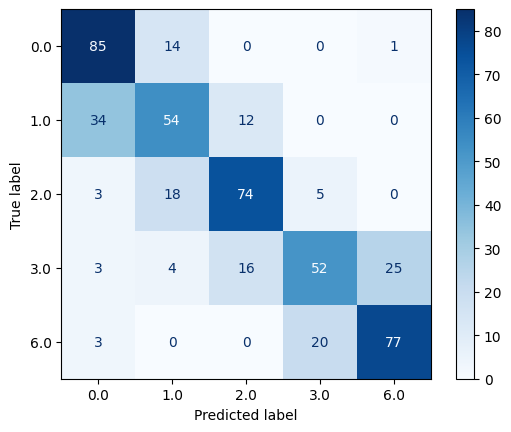

Report of Training:
              precision    recall  f1-score   support

         0.0       0.66      0.85      0.75       100
         1.0       0.60      0.54      0.57       100
         2.0       0.73      0.74      0.73       100
         3.0       0.68      0.52      0.59       100
         6.0       0.75      0.77      0.76       100

    accuracy                           0.68       500
   macro avg       0.68      0.68      0.68       500
weighted avg       0.68      0.68      0.68       500

14/14 [==============================] - 0s 408us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


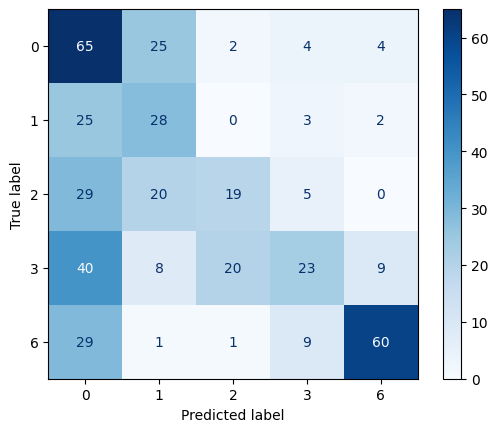

Report of Testing:
              precision    recall  f1-score   support

           0       0.35      0.65      0.45       100
           1       0.34      0.48      0.40        58
           2       0.45      0.26      0.33        73
           3       0.52      0.23      0.32       100
           6       0.80      0.60      0.69       100

    accuracy                           0.45       431
   macro avg       0.49      0.44      0.44       431
weighted avg       0.51      0.45      0.45       431

Train data is D1NAMO and test data is BigLab with threshold 75
16/16 [==============================] - 0s 383us/step


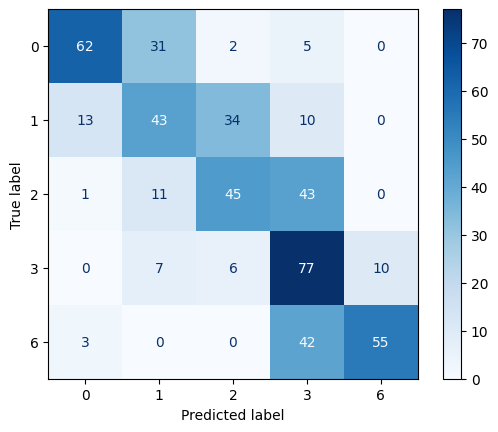

Report of Testing:
              precision    recall  f1-score   support

           0       0.78      0.62      0.69       100
           1       0.47      0.43      0.45       100
           2       0.52      0.45      0.48       100
           3       0.44      0.77      0.56       100
           6       0.85      0.55      0.67       100

    accuracy                           0.56       500
   macro avg       0.61      0.56      0.57       500
weighted avg       0.61      0.56      0.57       500



In [12]:
# Threshold 75 with sampling 100 and 5 classes

# The seed value needs to be called every time so that in every cell and order the model is reproduceable
# Seed value for reproducability according to https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras
seed_value=3
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# dictionaries are defined to undersample the data for each class, then the undersampling function is called
dict_under = {0: 100, 1: 100, 2: 100, 3: 100, 4: 0, 5: 0, 6: 100}
X_under_pre, y_under_pre = undersampling(X_pre, y_pre, dict_under)
dict_under_t1 = {0: 100, 1: 58, 2: 73, 3: 100, 4: 0, 5: 0, 6: 100}
X_under_t1, y_under_t1 = undersampling(X_t1, y_t1, dict_under_t1)

# the function start_model is called to initialize the model and visualize the confusion matrices
print("Train data is BigLab and test data is D1NAMO with threshold 75")
start_model(X_under_pre, y_under_pre, X_under_t1, y_under_t1, 5,"1DCNN_Trained_BigLab_75_100", "1DCNN_Tested_D1NAMO_75_100", batchsize=16, epoch= 500)
print("Train data is D1NAMO and test data is BigLab with threshold 75")
# trained D1NAMO model is loaded and tested on the BigLab data with 75 threshold
Testing_from_D1NAMO("Models/1DCNN_Trained_D1NAMO_70.hdf5", X_under_pre, y_under_pre, "Confusion_Matrices/1DCNN_Tested_BigLab_75_100.png")

## Threshold 80

In [13]:
# paths are defined and the load data function is called to have a time series representation of the data

# path for the data of type 2 pre-diabetes patients with a hypoglycemia threshold of 80 mg/dL
path_pre = 'data/prediab/thresh80'
X_pre, y_pre = load_data(path_pre)     

# path for the data of type 1 diabetes patients with a hypoglycemia threshold of 70 mg/dL
path_t1 = 'data/d1namo'
X_t1, y_t1 = load_data(path_t1)

Train data is BigLab and test data is D1NAMO with threshold 80


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5/5 [==============================] - 0s 510us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5/5 [==============================] - 0s 559us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5/5 [==============================] - 0s 482us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5/5 [==============================] - 0s 577us/step

Mean accuracy: 0.7701, Standard deviation: 0.0203 of trained model


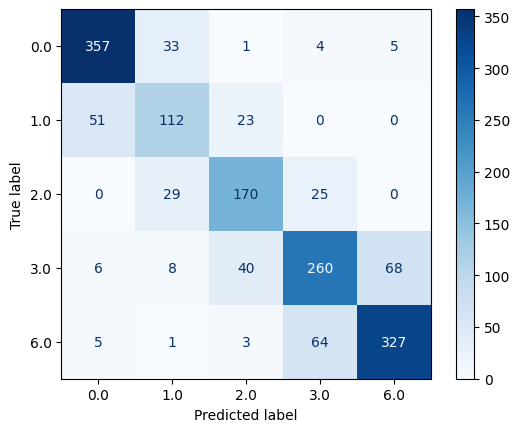

Report of Training:
              precision    recall  f1-score   support

         0.0       0.85      0.89      0.87       400
         1.0       0.61      0.60      0.61       186
         2.0       0.72      0.76      0.74       224
         3.0       0.74      0.68      0.71       382
         6.0       0.82      0.82      0.82       400

    accuracy                           0.77      1592
   macro avg       0.75      0.75      0.75      1592
weighted avg       0.77      0.77      0.77      1592

14/14 [==============================] - 0s 385us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


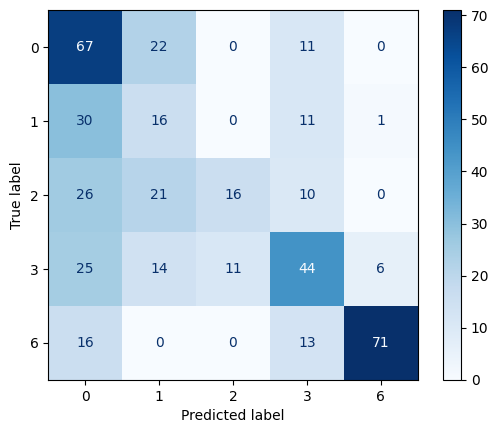

Report of Testing:
              precision    recall  f1-score   support

           0       0.41      0.67      0.51       100
           1       0.22      0.28      0.24        58
           2       0.59      0.22      0.32        73
           3       0.49      0.44      0.47       100
           6       0.91      0.71      0.80       100

    accuracy                           0.50       431
   macro avg       0.52      0.46      0.47       431
weighted avg       0.55      0.50      0.50       431

Train data is D1NAMO and test data is BigLab with threshold 80
50/50 [==============================] - 0s 349us/step


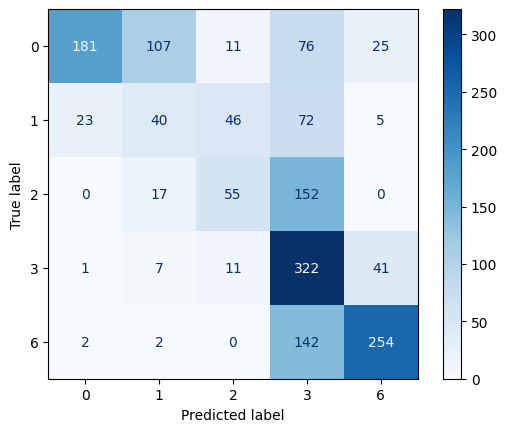

Report of Testing:
              precision    recall  f1-score   support

           0       0.87      0.45      0.60       400
           1       0.23      0.22      0.22       186
           2       0.45      0.25      0.32       224
           3       0.42      0.84      0.56       382
           6       0.78      0.64      0.70       400

    accuracy                           0.54      1592
   macro avg       0.55      0.48      0.48      1592
weighted avg       0.61      0.54      0.53      1592



In [14]:
# Threshold 80 with sampling 400 and 5 classes

# The seed value needs to be called every time so that in every cell and order the model is reproduceable
# Seed value for reproducability according to https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras
seed_value=3
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# dictionaries are defined to undersample the data for each class, then the undersampling function is called
dict_under = {0: 400, 1: 186, 2: 224, 3: 382, 4: 0, 5: 0, 6: 400}
X_under_pre, y_under_pre = undersampling(X_pre, y_pre, dict_under)
dict_under_t1 = {0: 100, 1: 58, 2: 73, 3: 100, 4: 0, 5: 0, 6: 100}
X_under_t1, y_under_t1 = undersampling(X_t1, y_t1, dict_under_t1)

# the function start_model is called to initialize the model and visualize the confusion matrices
print("Train data is BigLab and test data is D1NAMO with threshold 80")
start_model(X_under_pre, y_under_pre, X_under_t1, y_under_t1, 5,"1DCNN_Trained_BigLab_80_400", "1DCNN_Tested_D1NAMO_80_400", batchsize=40, epoch= 500)
print("Train data is D1NAMO and test data is BigLab with threshold 80")
# trained D1NAMO model is loaded and tested on the BigLab data with 80 threshold
Testing_from_D1NAMO("Models/1DCNN_Trained_D1NAMO_70.hdf5", X_under_pre, y_under_pre, "Confusion_Matrices/1DCNN_Tested_BigLab_80_400.png" )

Train data is BigLab and test data is D1NAMO with threshold 80


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 0s 544us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 0s 469us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 0s 473us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 0s 388us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 0s 511us/step

Mean accuracy: 0.7874, Standard deviation: 0.0257 of trained model


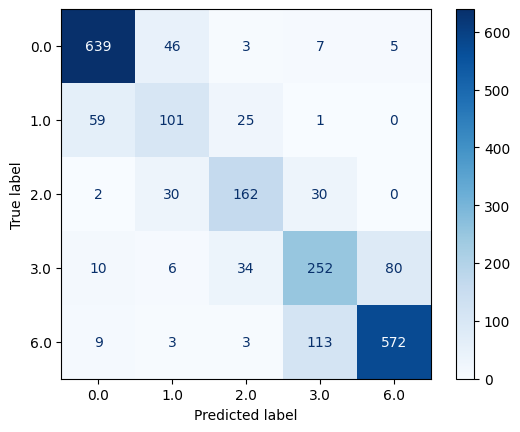

Report of Training:
              precision    recall  f1-score   support

         0.0       0.89      0.91      0.90       700
         1.0       0.54      0.54      0.54       186
         2.0       0.71      0.72      0.72       224
         3.0       0.63      0.66      0.64       382
         6.0       0.87      0.82      0.84       700

    accuracy                           0.79      2192
   macro avg       0.73      0.73      0.73      2192
weighted avg       0.79      0.79      0.79      2192

14/14 [==============================] - 0s 434us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


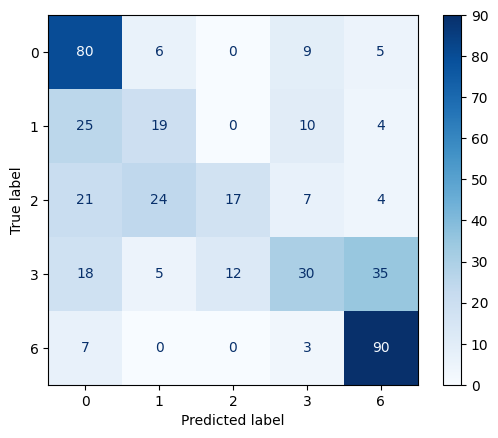

Report of Testing:
              precision    recall  f1-score   support

           0       0.53      0.80      0.64       100
           1       0.35      0.33      0.34        58
           2       0.59      0.23      0.33        73
           3       0.51      0.30      0.38       100
           6       0.65      0.90      0.76       100

    accuracy                           0.55       431
   macro avg       0.53      0.51      0.49       431
weighted avg       0.54      0.55      0.51       431

Train data is D1NAMO and test data is BigLab with threshold 80
69/69 [==============================] - 0s 348us/step


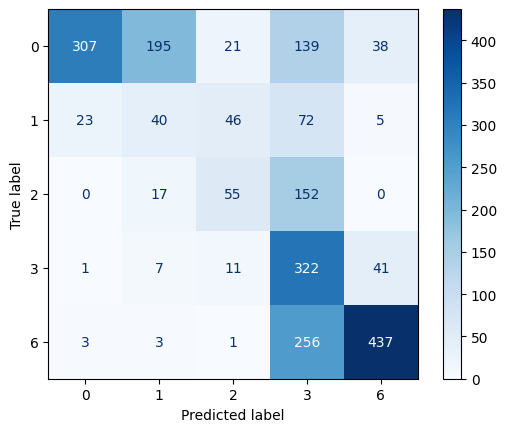

Report of Testing:
              precision    recall  f1-score   support

           0       0.92      0.44      0.59       700
           1       0.15      0.22      0.18       186
           2       0.41      0.25      0.31       224
           3       0.34      0.84      0.49       382
           6       0.84      0.62      0.72       700

    accuracy                           0.53      2192
   macro avg       0.53      0.47      0.46      2192
weighted avg       0.68      0.53      0.55      2192



In [15]:
# Threshold 80 with sampling 700 and 5 classes

# The seed value needs to be called every time so that in every cell and order the model is reproduceable
# Seed value for reproducability according to https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras
seed_value=3
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# dictionaries are defined to undersample the data for each class, then the undersampling function is called
dict_under = {0: 700, 1: 186, 2: 224, 3: 382, 4: 0, 5: 0, 6: 700}
X_under_pre, y_under_pre = undersampling(X_pre, y_pre, dict_under)
dict_under_t1 = {0: 100, 1: 58, 2: 73, 3: 100, 4: 0, 5: 0, 6: 100}
X_under_t1, y_under_t1 = undersampling(X_t1, y_t1, dict_under_t1)

# the function start_model is called to initialize the model and visualize the confusion matrices
print("Train data is BigLab and test data is D1NAMO with threshold 80")
start_model(X_under_pre, y_under_pre, X_under_t1, y_under_t1, 5,"1DCNN_Trained_BigLab_80_700", "1DCNN_Tested_D1NAMO_80_700", batchsize=50, epoch= 500)
print("Train data is D1NAMO and test data is BigLab with threshold 80")
# trained D1NAMO model is loaded and tested on the BigLab data with 80 threshold
Testing_from_D1NAMO("Models/1DCNN_Trained_D1NAMO_70.hdf5", X_under_pre, y_under_pre, "Confusion_Matrices/1DCNN_Tested_BigLab_80_700.png" )

## Threshold 85

In [16]:
# paths are defined and the load data function is called to have a time series representation of the data

# path for the data of type 2 pre-diabetes patients with a hypoglycemia threshold of 75 mg/dL
path_pre = 'data/prediab/thresh85'
X_pre, y_pre = load_data(path_pre)

# path for the data of type 1 diabetes patients with a hypoglycemia threshold of 70 mg/dL
path_t1 = 'data/d1namo'
X_t1, y_t1 = load_data(path_t1)

Train data is BigLab and test data is D1NAMO with threshold 85


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 470us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 444us/step

Mean accuracy: 0.7461, Standard deviation: 0.0316 of trained model


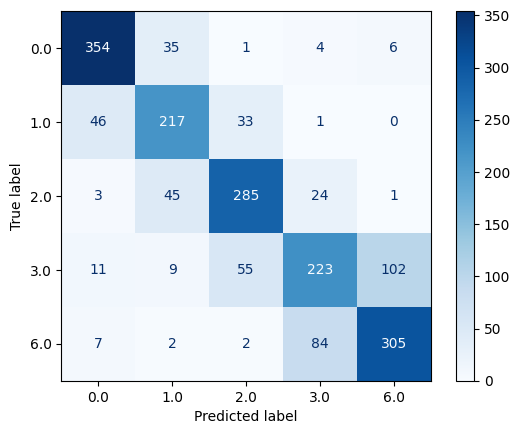

Report of Training:
              precision    recall  f1-score   support

         0.0       0.84      0.89      0.86       400
         1.0       0.70      0.73      0.72       297
         2.0       0.76      0.80      0.78       358
         3.0       0.66      0.56      0.61       400
         6.0       0.74      0.76      0.75       400

    accuracy                           0.75      1855
   macro avg       0.74      0.75      0.74      1855
weighted avg       0.74      0.75      0.74      1855

14/14 [==============================] - 0s 357us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


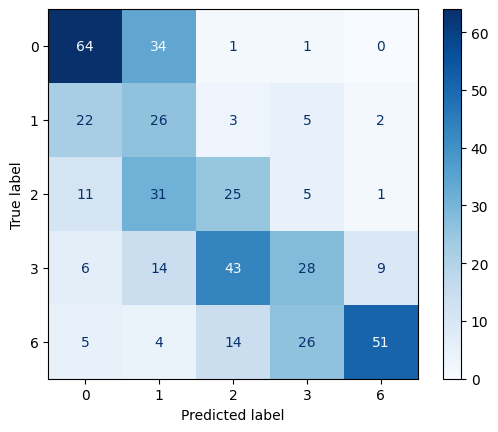

Report of Testing:
              precision    recall  f1-score   support

           0       0.59      0.64      0.62       100
           1       0.24      0.45      0.31        58
           2       0.29      0.34      0.31        73
           3       0.43      0.28      0.34       100
           6       0.81      0.51      0.63       100

    accuracy                           0.45       431
   macro avg       0.47      0.44      0.44       431
weighted avg       0.51      0.45      0.46       431

Train data is D1NAMO and test data is BigLab with threshold 85
58/58 [==============================] - 0s 319us/step


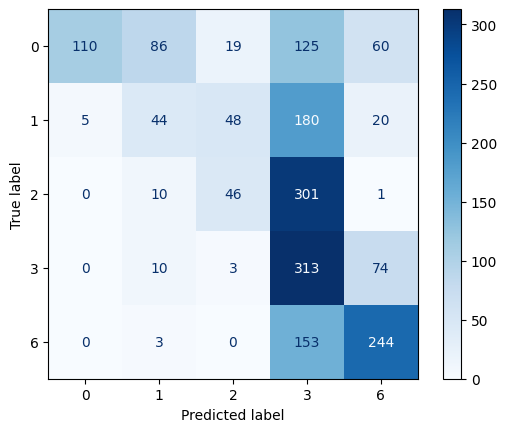

Report of Testing:
              precision    recall  f1-score   support

           0       0.96      0.28      0.43       400
           1       0.29      0.15      0.20       297
           2       0.40      0.13      0.19       358
           3       0.29      0.78      0.43       400
           6       0.61      0.61      0.61       400

    accuracy                           0.41      1855
   macro avg       0.51      0.39      0.37      1855
weighted avg       0.52      0.41      0.38      1855



In [17]:
# Threshold 85 with 400 sampling and 5 classes

# The seed value needs to be called every time so that in every cell and order the model is reproduceable
# Seed value for reproducability according to https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras
seed_value=3
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# dictionaries are defined to undersample the data for each class, then the undersampling function is called
dict_under = {0: 400, 1: 297, 2: 358, 3: 400,  4: 0, 5: 0, 6: 400}
X_under_pre, y_under_pre = undersampling(X_pre, y_pre, dict_under)
dict_under_t1 = {0: 100, 1: 58, 2: 73, 3: 100, 4: 0, 5: 0, 6: 100}
X_under_t1, y_under_t1 = undersampling(X_t1, y_t1, dict_under_t1)

# the function start_model is called to initialize the model and visualize the confusion matrices
print("Train data is BigLab and test data is D1NAMO with threshold 85")
start_model(X_under_pre, y_under_pre, X_under_t1, y_under_t1, 5,"1DCNN_Trained_BigLab_85_400", "1DCNN_Tested_D1NAMO_85_400", batchsize=50, epoch= 500)
print("Train data is D1NAMO and test data is BigLab with threshold 85")
# trained D1NAMO model is loaded and tested on the BigLab data with 85 threshold
Testing_from_D1NAMO("Models/1DCNN_Trained_D1NAMO_70.hdf5", X_under_pre, y_under_pre, "Confusion_Matrices/1DCNN_Tested_BigLab_85_400.png")

Train data is BigLab and test data is D1NAMO with threshold 85


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 0s 419us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 0s 396us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 0s 390us/step

Mean accuracy: 0.7537, Standard deviation: 0.0241 of trained model


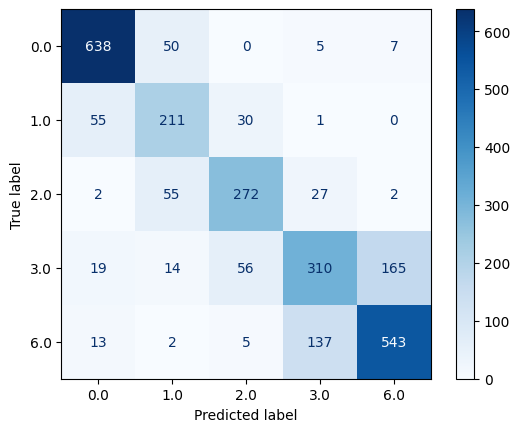

Report of Training:
              precision    recall  f1-score   support

         0.0       0.88      0.91      0.89       700
         1.0       0.64      0.71      0.67       297
         2.0       0.75      0.76      0.75       358
         3.0       0.65      0.55      0.59       564
         6.0       0.76      0.78      0.77       700

    accuracy                           0.75      2619
   macro avg       0.73      0.74      0.74      2619
weighted avg       0.75      0.75      0.75      2619

14/14 [==============================] - 0s 360us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


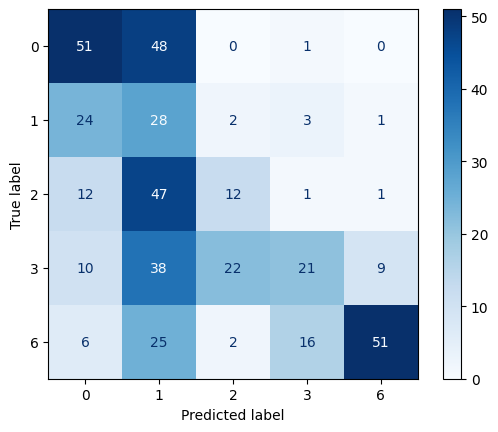

Report of Testing:
              precision    recall  f1-score   support

           0       0.50      0.51      0.50       100
           1       0.15      0.48      0.23        58
           2       0.32      0.16      0.22        73
           3       0.50      0.21      0.30       100
           6       0.82      0.51      0.63       100

    accuracy                           0.38       431
   macro avg       0.46      0.38      0.37       431
weighted avg       0.50      0.38      0.40       431

Train data is D1NAMO and test data is BigLab with threshold 85
82/82 [==============================] - 0s 296us/step


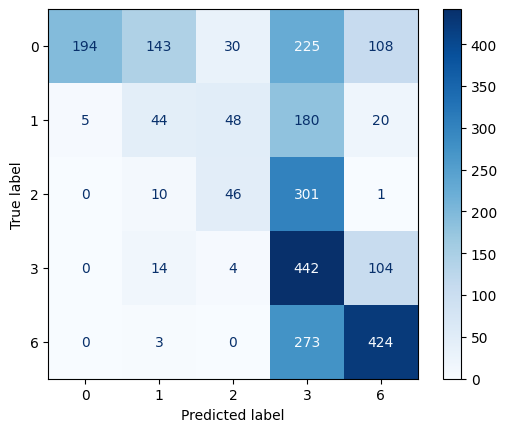

Report of Testing:
              precision    recall  f1-score   support

           0       0.97      0.28      0.43       700
           1       0.21      0.15      0.17       297
           2       0.36      0.13      0.19       358
           3       0.31      0.78      0.45       564
           6       0.65      0.61      0.62       700

    accuracy                           0.44      2619
   macro avg       0.50      0.39      0.37      2619
weighted avg       0.57      0.44      0.42      2619



In [18]:
# Threshold 85 with 700 sampling and 5 classes

# The seed value needs to be called every time so that in every cell and order the model is reproduceable
# Seed value for reproducability according to https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras
seed_value=3
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# dictionaries are defined to undersample the data for each class, then the undersampling function is called
dict_under = {0: 700, 1: 297, 2: 358, 3: 564,  4: 0, 5: 0, 6: 700}
X_under_pre, y_under_pre = undersampling(X_pre, y_pre, dict_under)
dict_under_t1 = {0: 100, 1: 58, 2: 73, 3: 100, 4: 0, 5: 0, 6: 100}
X_under_t1, y_under_t1 = undersampling(X_t1, y_t1, dict_under_t1)

# the function start_model is called to initialize the model and visualize the confusion matrices
print("Train data is BigLab and test data is D1NAMO with threshold 85")
start_model(X_under_pre, y_under_pre, X_under_t1, y_under_t1,5, "1DCNN_Trained_BigLab_85_700", "1DCNN_Tested_D1NAMO_85_700", batchsize=50, epoch= 500)
print("Train data is D1NAMO and test data is BigLab with threshold 85")
# trained D1NAMO model is loaded and tested on the BigLab data with 85 threshold
Testing_from_D1NAMO("Models/1DCNN_Trained_D1NAMO_70.hdf5", X_under_pre, y_under_pre, "Confusion_Matrices/1DCNN_Tested_BigLab_85_700.png")

Train data is BigLab and test data is D1NAMO with threshold 85


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 0s 365us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 0s 385us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 0s 384us/step

Mean accuracy: 0.7766, Standard deviation: 0.0146 of trained model


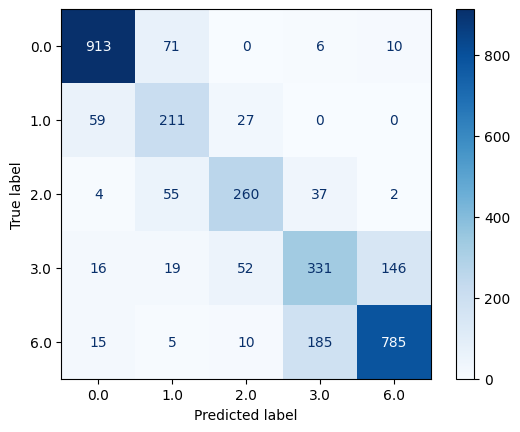

Report of Training:
              precision    recall  f1-score   support

         0.0       0.91      0.91      0.91      1000
         1.0       0.58      0.71      0.64       297
         2.0       0.74      0.73      0.74       358
         3.0       0.59      0.59      0.59       564
         6.0       0.83      0.79      0.81      1000

    accuracy                           0.78      3219
   macro avg       0.73      0.74      0.74      3219
weighted avg       0.78      0.78      0.78      3219

14/14 [==============================] - 0s 398us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


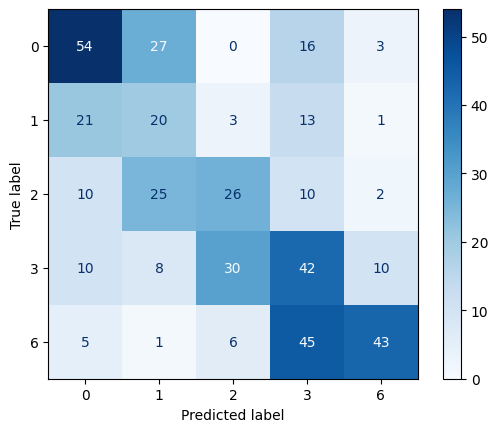

Report of Testing:
              precision    recall  f1-score   support

           0       0.54      0.54      0.54       100
           1       0.25      0.34      0.29        58
           2       0.40      0.36      0.38        73
           3       0.33      0.42      0.37       100
           6       0.73      0.43      0.54       100

    accuracy                           0.43       431
   macro avg       0.45      0.42      0.42       431
weighted avg       0.47      0.43      0.44       431

Train data is D1NAMO and test data is BigLab with threshold 85
101/101 [==============================] - 0s 304us/step


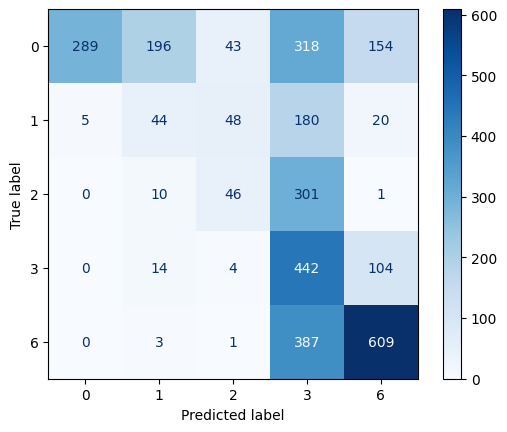

Report of Testing:
              precision    recall  f1-score   support

           0       0.98      0.29      0.45      1000
           1       0.16      0.15      0.16       297
           2       0.32      0.13      0.18       358
           3       0.27      0.78      0.40       564
           6       0.69      0.61      0.65      1000

    accuracy                           0.44      3219
   macro avg       0.49      0.39      0.37      3219
weighted avg       0.62      0.44      0.44      3219



In [19]:
# Threshold 85 with 1000 sampling and 5 classes

# The seed value needs to be called every time so that in every cell and order the model is reproduceable
# Seed value for reproducability according to https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras
seed_value=3
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# dictionaries are defined to undersample the data for each class, then the undersampling function is called
dict_under = {0: 1000, 1: 297, 2: 358, 3: 564, 4: 0, 5: 0, 6: 1000}
X_under_pre, y_under_pre = undersampling(X_pre, y_pre, dict_under)
dict_under_t1 = {0: 100, 1: 58, 2: 73, 3: 100, 4: 0, 5: 0, 6: 100}
X_under_t1, y_under_t1 = undersampling(X_t1, y_t1, dict_under_t1)

# the function start_model is called to initialize the model and visualize the confusion matrices
print("Train data is BigLab and test data is D1NAMO with threshold 85")
start_model(X_under_pre, y_under_pre, X_under_t1, y_under_t1,5, "1DCNN_Trained_BigLab_85_1000", "1DCNN_Tested_D1NAMO_85_1000", batchsize=50, epoch= 500)
print("Train data is D1NAMO and test data is BigLab with threshold 85")
# trained D1NAMO model is loaded and tested on the BigLab data with 85 threshold
Testing_from_D1NAMO("Models/1DCNN_Trained_D1NAMO_70.hdf5", X_under_pre, y_under_pre, "Confusion_Matrices/1DCNN_Tested_BigLab_85_1000.png")